<a href="https://colab.research.google.com/github/ritwiks9635/Image_Captioning/blob/main/Image_Captioning_using_CoCoData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[COCO Dataset](awsaf49/coco-2017-dataset)

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/awsaf49/coco-2017-dataset/coco-2017-dataset.zip

In [3]:
!rm -r /content/https:
!rm -r /content/coco2017/val2017

#**Image Captioning Model using CoCo Dataset**

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import json
import re
import os
import matplotlib.pyplot as plt
from PIL import Image
import collections

In [2]:
max_length = 40
vocab_size = 15000
batch_size = 4
buffer_size = 1000
embedding_dim = 512
units = 512
epochs = 5

In [3]:
data_dir = "/content/coco2017"
with open(f'{data_dir}/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data["annotations"]
    print(data[0])

img_and_caption =[]
for sample in data:
    img_name = '%012d.jpg' % sample['image_id']
    img_and_caption.append([img_name, sample["caption"]])

caption_data = pd.DataFrame(img_and_caption, columns = ["image", "caption"])
caption_data["image"] = caption_data["image"].apply(lambda x : os.path.join(data_dir, "train2017", x))
caption_data = caption_data.sample(20000)
caption_data = caption_data.reset_index(drop = True)
print(caption_data.shape)
caption_data.head()

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}
(20000, 2)


,image,caption
0,/content/coco2017/train2017/000000059358.jpg,A girl in red is standing in front of the gira...
1,/content/coco2017/train2017/000000046432.jpg,A photo taken from an airplane looking down at...
2,/content/coco2017/train2017/000000457037.jpg,A nicely decorated bedroom with furniture and ...
3,/content/coco2017/train2017/000000385196.jpg,A group of people riding skateboards across a ...
4,/content/coco2017/train2017/000000548706.jpg,A bathroom with checkered tile and maroon towels.


In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = '[start] ' + text + ' [end]'
    return text

In [5]:
caption_data["caption"] = caption_data["caption"].apply(preprocess)
caption_data.head()

,image,caption
0,/content/coco2017/train2017/000000059358.jpg,[start] a girl in red is standing in front of ...
1,/content/coco2017/train2017/000000046432.jpg,[start] a photo taken from an airplane looking...
2,/content/coco2017/train2017/000000457037.jpg,[start] a nicely decorated bedroom with furnit...
3,/content/coco2017/train2017/000000385196.jpg,[start] a group of people riding skateboards a...
4,/content/coco2017/train2017/000000548706.jpg,[start] a bathroom with checkered tile and mar...


[start] a photo taken from an airplane looking down at the mountains [end]



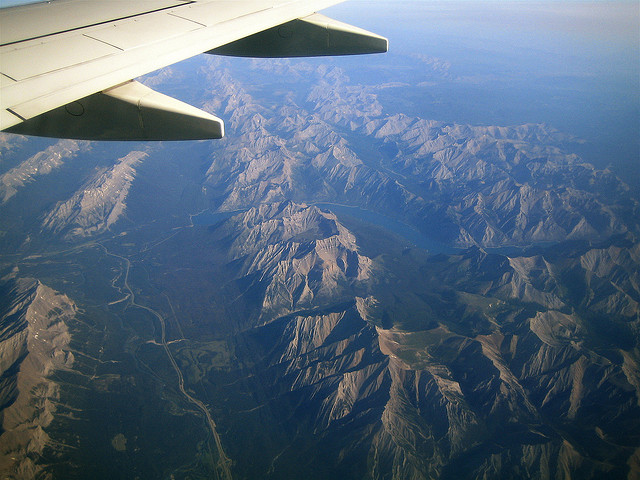

In [6]:
sample_1 = caption_data.iloc[1]
print(sample_1.caption)
print()
img = Image.open(sample_1.image)
img

In [7]:
tokenizer = layers.TextVectorization(
    max_tokens = vocab_size,
    standardize = None,
    output_sequence_length = max_length)

tokenizer.adapt(caption_data["caption"])

In [8]:
tokenizer.vocabulary_size()

6896

In [9]:
word2idx = layers.StringLookup(
    mask_token = "",
    vocabulary = tokenizer.get_vocabulary())

idx2word = layers.StringLookup(
    mask_token = "",
    vocabulary = tokenizer.get_vocabulary(),
    invert = True)

In [10]:
import random

img_cap_dict = collections.defaultdict(list)

for img, cap in zip(caption_data["image"], caption_data["caption"]):
    img_cap_dict[img].append(cap)

img_path = list(img_cap_dict.keys())
random.shuffle(img_path)

split_idx = int(len(img_path) * 0.8)
train_img_path, val_img_path = (img_path[: split_idx], img_path[split_idx:])
#print(len(train_img_path))
#print(len(val_img_path))

train_images = []
train_captions = []
for img_tr in train_img_path:
    cap_len = len(img_cap_dict[img_tr])
    train_images.extend([img_tr] * cap_len)
    train_captions.extend(img_cap_dict[img_tr])



val_images = []
val_captions = []
for img_vl in val_img_path:
    cap_len = len(img_cap_dict[img_vl])
    val_images.extend([img_vl] * cap_len)
    val_captions.extend(img_cap_dict[img_vl])

print(len(train_images), len(train_captions), len(val_images), len(val_captions))

15997 15997 4003 4003


In [11]:
def load_data(img_paths, captions):
    image = tf.io.read_file(img_paths)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = layers.Resizing(299, 299)(image)
    image = keras.applications.inception_v3.preprocess_input(image)
    caption = tokenizer(captions)
    return image, caption

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_captions))
train_dataset = train_dataset.map(load_data, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size)

valid_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_captions))
valid_dataset = valid_dataset.map(load_data, num_parallel_calls = tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.shuffle(buffer_size)

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor = 0.2),
        layers.RandomContrast(0.3)
    ])

In [14]:
def cnn_encoder():
    inception = keras.applications.InceptionV3(include_top = False, weights = "imagenet")
    output = inception.output
    output = layers.Reshape((-1, output.shape[-1]))(output)

    model = keras.Model(inception.input, output)
    return model

In [15]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.attention = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.dense = layers.Dense(embed_dim, activation = "relu")


    def call(self, inputs, training):
        x = self.layernorm_1(inputs)
        x = self.dense(x)
        attn_output = self.attention(
            query = x,
            key = x,
            value = x,
            attention_mask = None,
            training = training)
        x = self.layernorm_2(x + attn_output)
        return x

In [16]:
class Embedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim,
        self.max_len = max_len

        self.token_embed = layers.Embedding(input_dim = vocab_size, output_dim = embed_dim)
        self.pos_embed = layers.Embedding(input_dim = max_len, output_dim = embed_dim, input_shape = (None, max_len))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        position = tf.range(start = 0, limit = length, delta = 1)
        position = tf.expand_dims(position, axis = 0)
        token_embed = self.token_embed(inputs)
        posi_embed = self.pos_embed(position)
        return token_embed + posi_embed

In [17]:
class TransformerDecoderLayer(layers.Layer):

    def __init__(self, embed_dim, units, num_heads):
        super().__init__()
        self.embedding = Embedding(tokenizer.vocabulary_size(), embed_dim, max_length)

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.ffn_layer_1 = layers.Dense(units, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.out = layers.Dense(tokenizer.vocabulary_size(), activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)


    def call(self, inputs, encoder_output, training, mask=None):
        embeddings = self.embedding(inputs)

        combined_mask = None
        padding_mask = None

        if mask is not None:
            causal_mask = self.get_causal_attention_mask(embeddings)
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attn_output_1 = self.attention_1(
            query=embeddings,
            value=embeddings,
            key=embeddings,
            attention_mask=combined_mask,
            training=training
        )

        out_1 = self.layernorm_1(embeddings + attn_output_1)

        attn_output_2 = self.attention_2(
            query=out_1,
            value=encoder_output,
            key=encoder_output,
            attention_mask=padding_mask,
            training=training
        )

        out_2 = self.layernorm_2(out_1 + attn_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds


    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [18]:
class ImageCaptioningModel(tf.keras.Model):

    def __init__(self, cnn_model, encoder, decoder, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.image_aug = image_aug
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")


    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)


    def compute_loss_and_acc(self, img_embed, captions, training=True):
        encoder_output = self.encoder(img_embed, training=True)
        y_input = captions[:, :-1]
        y_true = captions[:, 1:]
        mask = (y_true != 0)
        y_pred = self.decoder(
            y_input, encoder_output, training=True, mask=mask
        )
        loss = self.calculate_loss(y_true, y_pred, mask)
        acc = self.calculate_accuracy(y_true, y_pred, mask)
        return loss, acc


    def train_step(self, batch):
        imgs, captions = batch

        if self.image_aug:
            imgs = self.image_aug(imgs)

        img_embed = self.cnn_model(imgs)

        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss_and_acc(
                img_embed, captions
            )

        train_vars = (
            self.encoder.trainable_variables + self.decoder.trainable_variables
        )
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}


    def test_step(self, batch):
        imgs, captions = batch

        img_embed = self.cnn_model(imgs)

        loss, acc = self.compute_loss_and_acc(
            img_embed, captions, training=False
        )

        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [19]:
encoder = TransformerEncoder(embed_dim = embedding_dim, num_heads = 1)
decoder = TransformerDecoderLayer(embed_dim = embedding_dim, units = units, num_heads = 8)

cnn_model = cnn_encoder()
caption_model = ImageCaptioningModel(cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=data_augmentation,)

In [20]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

caption_model.compile(
    optimizer= keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction="none")
)

In [21]:
history = caption_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping_cb]
)

Epoch 1/5
4000/4000 [==============================] - 353s 77ms/step - loss: 5.5565 - acc: 0.1396 - val_loss: 5.4509 - val_acc: 0.1450
Epoch 2/5
4000/4000 [==============================] - 295s 68ms/step - loss: 5.4206 - acc: 0.1436 - val_loss: 5.4941 - val_acc: 0.1490
Epoch 3/5
4000/4000 [==============================] - 317s 74ms/step - loss: 5.4262 - acc: 0.1437 - val_loss: 5.4882 - val_acc: 0.1457


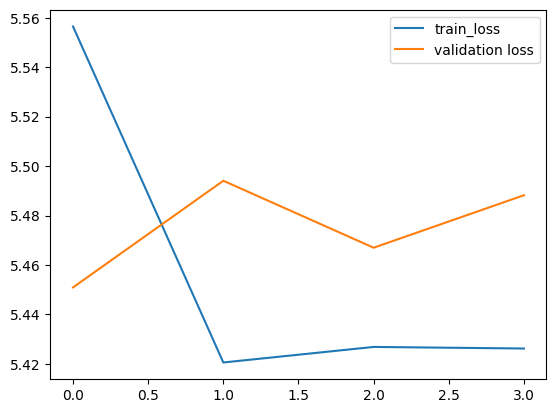

In [22]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [25]:
def load_image_from_path(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def generate_caption(img_path, add_noise=False):
    img = load_image_from_path(img_path)

    if add_noise:
        noise = tf.random.normal(img.shape)*0.1
        img = img + noise
        img = (img - tf.reduce_min(img))/(tf.reduce_max(img) - tf.reduce_min(img))

    img = tf.expand_dims(img, axis=0)
    img_embed = caption_model.cnn_model(img)
    img_encoded = caption_model.encoder(img_embed, training=False)

    y_inp = '[start]'
    for i in range(max_length -1):
        tokenized = tokenizer([y_inp])[:, :-1]
        mask = tf.cast(tokenized != 0, tf.int32)
        pred = caption_model.decoder(
            tokenized, img_encoded, training=False, mask=mask)

        pred_idx = np.argmax(pred[0, i, :])
        pred_idx = tf.convert_to_tensor(pred_idx)
        pred_word = idx2word(pred_idx).numpy().decode('utf-8')
        if pred_word == '[end]':
            break

        y_inp += ' ' + pred_word

    y_inp = y_inp.replace('[start] ', '')
    return y_inp

Here i am use 10000 dataset if train 70000 or epochs is >= 10 so get better results

Predicted Caption: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a



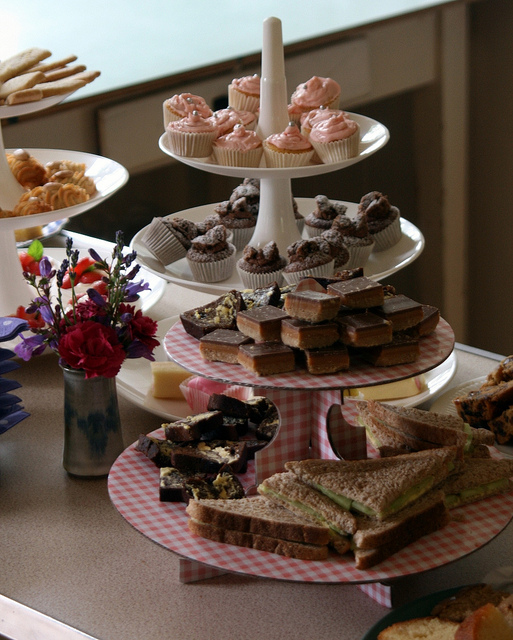

In [28]:
idx = random.randrange(0, len(caption_data))
img_path = caption_data.iloc[idx].image

pred_caption = generate_caption(img_path)
print('Predicted Caption:', pred_caption)
print()
Image.open(img_path)